In [1]:
# Various imports, setup
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns

In [2]:
################
# Read in Data #
################
# For source see '../src/data_sources'

# USGS; 1980 to today, only 6.5+ quakes. 
usgs_quakes = pd.read_csv('../data/raw/usgs_1980_6_5_above.csv')

# NOAA; I think its 1980 to today - josh
noaa_quakes = pd.read_csv('../data/raw/noaa_quakes.tsv', sep='\t')

In [4]:
# What are the magtypes? 
usgs_quakes['magType'].value_counts()

mw     571
mwc    519
mww    448
mwb    225
ms      84
mb      11
ml       3
mh       3
md       3
Mi       1
Name: magType, dtype: int64

# Hypothesis 1
- Deaths correlated with time?  (are we more prepared for earthquakes)
- Are deaths changing over time? (controlling for magnitude)


In [100]:
# Subset just the variables we want for this analysis
data_h1 = noaa_quakes[['Year', 'Mag', 'Total Deaths', 'Deaths', 'Damage ($Mil)', 'Total Missing', 'Total Injuries']]
# remove NA for outcome of interest
data_h1 = data_h1[data_h1['Total Deaths'].notna()]
data_h1.shape


(814, 7)

In [97]:
data_h1.corr()

,Year,Mag,Total Deaths
Year,1.000000,-0.029346,0.013920
Mag,-0.029346,1.000000,0.127745
Total Deaths,0.013920,0.127745,1.000000


In [98]:
data_h1['Year'].value_counts()

2019.0    40
2017.0    35
2018.0    33
2016.0    29
2008.0    28
1990.0    26
2003.0    26
2002.0    26
1999.0    25
2004.0    25
2007.0    21
2012.0    21
2013.0    20
2011.0    20
1983.0    20
2015.0    20
2010.0    20
2014.0    19
2009.0    19
1991.0    19
1998.0    19
1989.0    19
1994.0    18
1987.0    18
2005.0    18
1995.0    17
2006.0    17
1980.0    17
1997.0    17
1985.0    16
1981.0    15
1986.0    15
2000.0    15
1992.0    14
2020.0    14
2001.0    13
1984.0    13
1993.0    12
1988.0    11
1982.0    11
1996.0     9
2021.0     2
Name: Year, dtype: int64

In [49]:
# Bin magnitudes? by 0.5 then replace as y-axis
alt.Chart(data_h1).mark_rect().encode(
    x='Year:N',
    y=alt.Y('Mag:N', scale=alt.Scale(reverse=True)),
    color='Total Deaths:Q'
)

alt.Chart(...)

<AxesSubplot:>

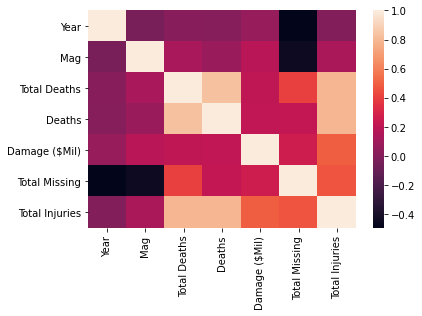

In [9]:
corr = data_h1.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
# As years increase, total number missing decreases


In [10]:
data_h1.describe()
# Deaths outlier

,Year,Mag,Total Deaths,Deaths,Damage ($Mil),Total Missing,Total Injuries
count,1848.000000,1845.000000,814.000000,795.000000,342.000000,23.000000,974.000000
mean,2002.848485,6.020434,1224.626536,935.232704,1774.089351,182.304348,1783.850103
std,11.309965,1.031762,14410.850090,12142.857550,8166.938032,396.996386,17508.094491
min,1980.000000,1.600000,1.000000,1.000000,0.300000,1.000000,1.000000
25%,1994.000000,5.300000,1.000000,1.000000,5.000000,4.000000,8.000000
50%,2005.000000,6.000000,4.000000,4.000000,41.500000,17.000000,35.000000
75%,2012.000000,6.800000,24.000000,22.000000,408.175000,126.000000,174.000000
max,2021.000000,9.100000,316000.000000,316000.000000,100000.000000,1755.000000,374171.000000


In [13]:
# Definitely an outlier in 2010 and 2004 that were very deadly
data_h1.sort_values('Total Deaths')

,Year,Mag,Total Deaths,Deaths,Damage ($Mil),Total Missing,Total Injuries
828,2003.0,6.5,1.0,1.0,NaN,NaN,21.0
1091,2007.0,5.1,1.0,1.0,NaN,NaN,NaN
1090,2007.0,5.1,1.0,1.0,NaN,NaN,5.0
1088,2007.0,4.8,1.0,1.0,NaN,NaN,12.0
1050,2007.0,6.7,1.0,1.0,NaN,NaN,150.0
...,...,...,...,...,...,...,...
342,1990.0,7.3,40000.0,40000.0,7200.0,NaN,105000.0
964,2005.0,7.6,76213.0,76213.0,6680.0,NaN,146599.0
1132,2008.0,7.9,87652.0,87652.0,86000.0,NaN,374171.0
916,2004.0,9.1,227899.0,1001.0,10000.0,NaN,NaN


# Hypothesis 2
- Have certain “hard hit” countries gotten better at preparing over time?
- Make graph, x-axis magnitude, y-axis deaths, colored/grouped by country, by time
- Subset for necessarily variables: Mag, Total Deaths, Country, Year

In [86]:
data_h2 = noaa_quakes[['Year', 'Mag', 'Total Deaths', 'Location Name']]

# Make a new feature called 'Location' which takes the first word from 'Location Name'
# 'Location Name' has 1510 distinct categories
# 'Location' has 181

data_h2 = data_h2.assign(Location=data_h2['Location Name'].str.split(':').str[0])
# Remove NA (removes over 1000 observations, out of 1800)
data_h2 = data_h2.dropna()

In [87]:
data_h2.shape


(812, 5)

#### Time to start the chart! First I want to create a simple scatter plot with  Total Deaths on the vertical axis and Magnitude on the horizontal axis 

In [111]:
alt.Chart(data_h2).mark_circle(filled=True, 
                                size=200, 
                                opacity=0.9, 
                                color='tableau20').encode(
    x=alt.X('Mag', title='Magnitude'),
    y=alt.Y('Total Deaths', title='Total Deaths'),
    color=alt.Color('Location', legend=alt.Legend(title='Location')),
).configure_axis(
    tickCount=10
).properties(
    title='Earthquake test',
    width=600,
    height=400
)

alt.Chart(...)

I can't see all of the entries, the location variable has 81 entries; too many to understand, I can't really see what is going on with all of the dots at the bottom, but I do see that there are some outliers with high magnitudes and very high death counts. 

Next Lets add a Tooltip and interactivity so we can identify some of the points. We might also want to make them smaller since there are so many.

In [112]:
alt.Chart(data_h2).mark_circle(filled=True, 
                                size=100, 
                                opacity=0.9, 
                                color='tableau20').encode(
    x=alt.X('Mag', title='Magnitude'),
    y=alt.Y('Total Deaths', title='Total Deaths'),
    color=alt.Color('Location', legend=alt.Legend(title='Location')),
    tooltip=['Location', 'Mag', 'Total Deaths']
).configure_axis(
    tickCount=10
).properties(
    title='Earthquake test',
    width=600,
    height=400
).interactive()

alt.Chart(...)

Now we can zoom in and start to inspect individual points. However, I want to add more data to the tooltip than what is just on the graph already. Instead of included the truncated location variable created above, we will include the full location name. To better examine this data in the context of our hypothesis, we will also add the Year. 

In [113]:
alt.Chart(data_h2).mark_circle(filled=True, 
                                size=100, 
                                opacity=0.9, 
                                color='tableau20').encode(
    x=alt.X('Mag', title='Magnitude'),
    y=alt.Y('Total Deaths', title='Total Deaths'),
    color=alt.Color('Location', legend=alt.Legend(title='Location')),
    tooltip=['Location Name', 'Year', 'Mag', 'Total Deaths']
).configure_axis(
    tickCount=10
).properties(
    title='Earthquake test',
    width=600,
    height=400
).interactive()

alt.Chart(...)

It looks like a lot of the data is clumped together around 0 deaths. I want to inspect only the fatal earthquakes to compare them 

In [115]:

data_h2_fatal = data_h2[data_h2['Total Deaths'] > 0]

In [116]:
alt.Chart(data_h2_fatal).mark_circle(filled=True, 
                                size=100, 
                                opacity=0.9, 
                                color='tableau20').encode(
    x=alt.X('Mag', title='Magnitude'),
    y=alt.Y('Total Deaths', title='Total Deaths'),
    color=alt.Color('Location', legend=alt.Legend(title='Location')),
    tooltip=['Location Name', 'Year', 'Mag', 'Total Deaths']
).configure_axis(
    tickCount=10
).properties(
    title='Earthquake test',
    width=600,
    height=400
).interactive()

alt.Chart(...)

There are still many bunched around at the bottom. Now I want to inspect only the 'big ones'. I would like to graph only the earthquakes with > 1000 deaths

In [102]:
data_h2_bigones = data_h2[data_h2['Total Deaths'] > 10000]

In [117]:
alt.Chart(data_h2_bigones).mark_circle(filled=True, 
                                size=100, 
                                opacity=0.9, 
                                color='tableau20').encode(
    x=alt.X('Mag', title='Magnitude'),
    y=alt.Y('Total Deaths', title='Total Deaths'),
    color=alt.Color('Location', legend=alt.Legend(title='Location')),
    tooltip=['Location Name', 'Year', 'Mag', 'Total Deaths']
).configure_axis(
    tickCount=10
).properties(
    title='Earthquake test',
    width=600,
    height=400
).interactive()

alt.Chart(...)

Now we can really look in and inspect the hard hit countries in this data set. There is too little information to see if certain countries have gotten better at preventing deaths. We may have to take the data to a little farther back in time.  